#credit card fraud detaction - EDA,Feature Engineering & Model Comparison

In [36]:
# Setup - imports
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (precision_recall_curve ,average_precision_score,roc_auc_score,classification_report,confusion_matrix,precision_score,recall_score,f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#Optional models
try:
    import xgboost as xgb
except Exception as e:
    xgb = None
    print('XGBoost not available:',e)
try:
    import lightgbm as lgb
except Exception as e:
    lgb = None
    print('LightGBM not available:',e)
import joblib 
print('setup complete')










setup complete


In [37]:
# 1. Load data 
import os
import pandas as pd

DATA_PATH = "creditcard.csv"

assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
df.head()




,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Rows, Columns: (284807, 31)
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Missing values (top 20): 
 Time      0
V16       0
Amount    0
V28       0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
V21       0
V20       0
V19       0
V18       0
V17       0
V15       0
V1        0
V14       0
V13       0
V12       0
dtype: int64

Target distribution:
0    284315
1       492
Name: Class, dtype: int64
fraud ratio: 0.001727485630620034


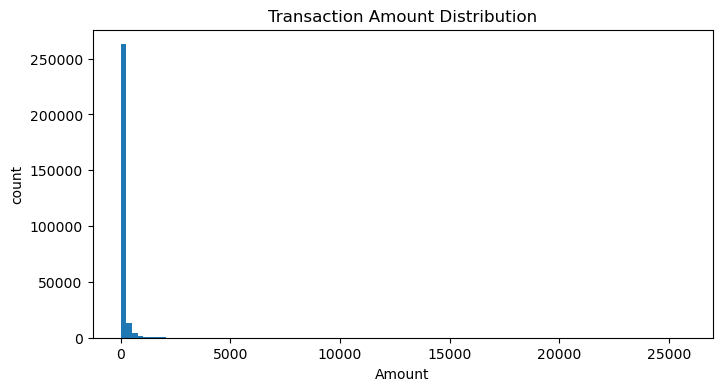

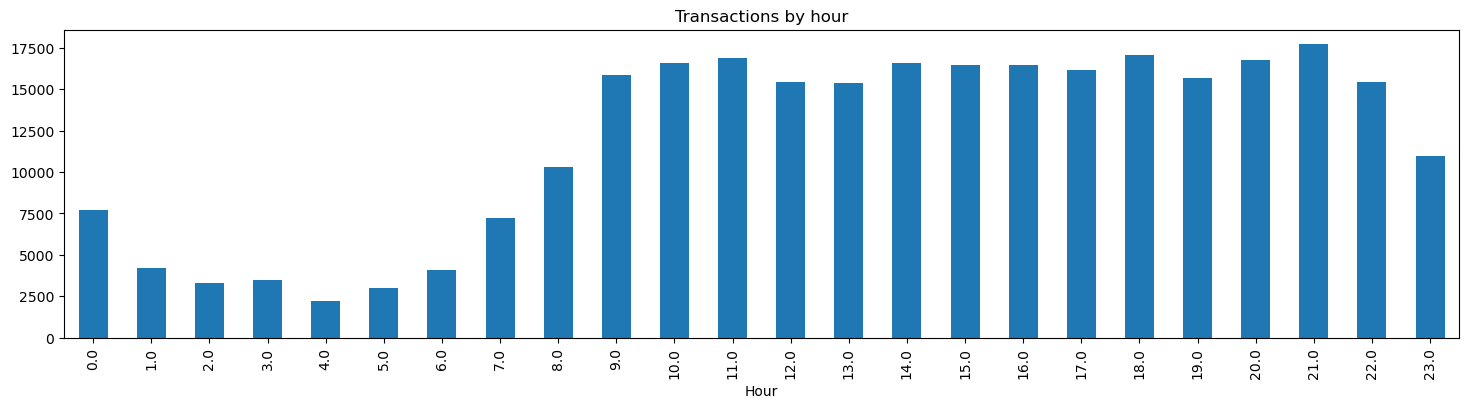

In [38]:
# 2. Quick EDA 
print('Rows, Columns:', df.shape)
print(df.dtypes)
print('\nMissing values (top 20): \n', df.isnull().sum().sort_values(ascending=False).head(20))
target_col = 'Class'
print('\nTarget distribution:')
print(df[target_col].value_counts())
print('fraud ratio:', df[target_col].mean())

#Amount distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(df['Amount'], bins=100)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('count')
plt.show()

#Time-based overview (the dataset's Time columnin seconds since first transaction)
if 'Time' in df.columns:
    df['Hour'] = (df['Time'] // 3600) % 24
    plt.figure(figsize=(18,4))
    df.groupby('Hour').size().plot(kind='bar')
    plt.title('Transactions by hour')
    plt.show()             

#Data Analysis

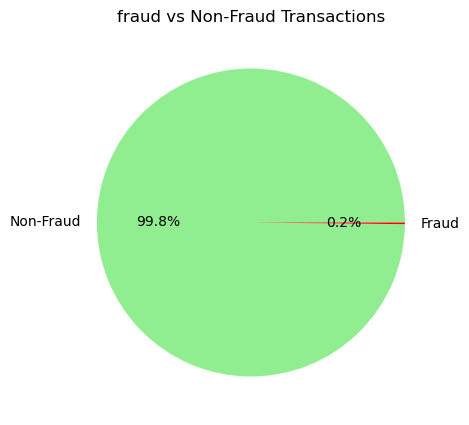

In [39]:
#pie chart
plt.figure(figsize=(5,5))
plt.pie(df['Class'].value_counts().values,labels=['Non-Fraud', 'Fraud'],autopct='%1.1f%%',colors=['lightgreen','red'])
plt.title('fraud vs Non-Fraud Transactions')
plt.show()

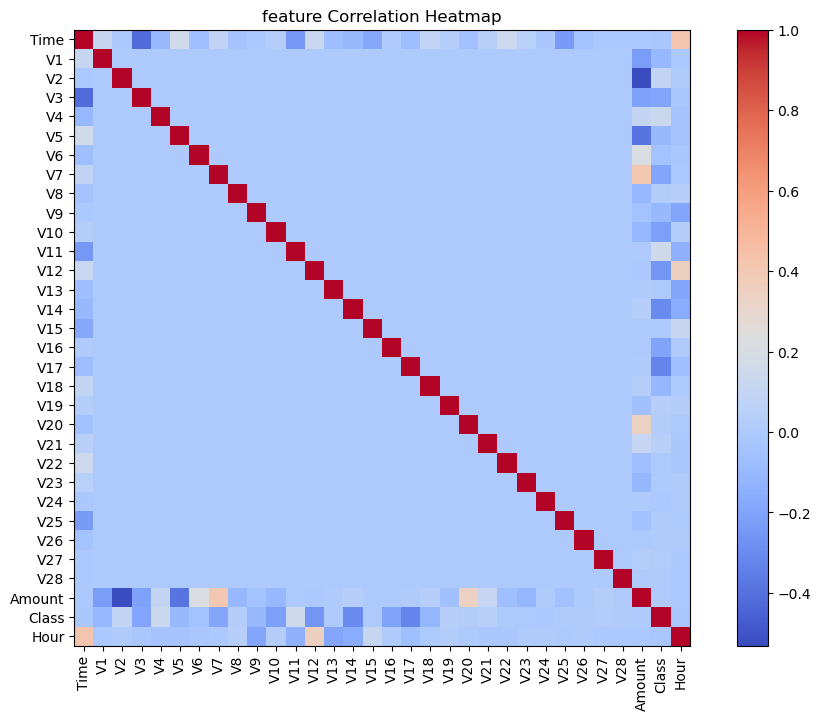

In [40]:
#Correlation Heatmap
plt.figure(figsize=(12,8))
corr = df.corr()
plt.imshow(corr,cmap='coolwarm',interpolation ='nearest')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('feature Correlation Heatmap')
plt.show()

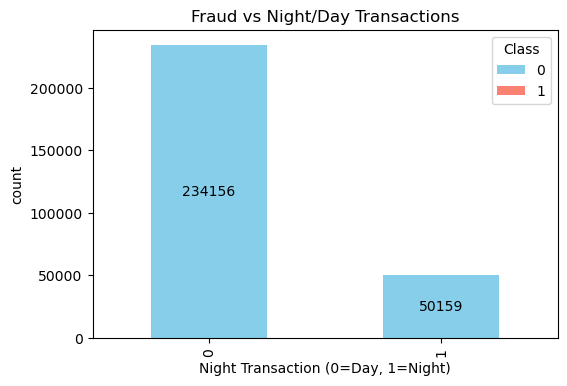

In [41]:
# Night vs Day fraud
df['is_night'] = df['Hour'].isin([22,23,0,1,2,3,4,5]).astype(int)

night_fraud = df.groupby(['is_night','Class']).size().unstack(fill_value=0)
ax = night_fraud.plot(kind='bar',stacked=True,figsize=(6, 4),color=['skyblue', 'salmon'])


plt.xlabel('Night Transaction (0=Day, 1=Night)')
plt.ylabel('count')
plt.title('Fraud vs Night/Day Transactions')
for container in ax.containers:
    ax.bar_label(container,label_type='center',fmt='%d')
    plt.show()


Preparing Data For Model Creation

In [42]:
# 3. Feature Engineering (basic)
# We will create a few straightforward features that often help:
# - log_amount
# - amount_to_mean_ratio (global mean)
# - is_high_amount (amount above 99th percentile)

df_fe = df.copy()

# Log transform
import numpy as np

df_fe['log_amount'] = np.log1p(df_fe['Amount'])

# Amount to global mean
global_mean = df_fe['Amount'].mean()
df_fe['amount_to_mean'] = df_fe['Amount'] / (global_mean + 1e-9)

# High amount flag (above 99th percentile)
p99 = df_fe['Amount'].quantile(0.99)
df_fe['is_high_amount'] = (df_fe['Amount'] > p99).astype(int)

# Hour / night feature
if 'Hour' in df_fe.columns:
    df_fe['is_night'] = df_fe['Hour'].isin([0, 1, 2, 3, 4, 5, 22, 23]).astype(int)
else:
    df_fe['is_night'] = 0

# Drop target column from features
X = df_fe.drop(columns=[target_col])
y = df_fe[target_col].values

print('Feature engineering complete. X shape:', X.shape)


Feature engineering complete. X shape: (284807, 35)


In [43]:
# 4. Train / Test split (Stratified)
# from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


print(X_train.shape, X_test.shape)

# Scaling numeric features
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler.fit(X_train[numeric_features])

def prep(X_df):
    Xc = X_df.copy()
    Xc[numeric_features] = scaler.transform(Xc[numeric_features])

    # drop Time column to avoid leakage of absolute timestamp
    if 'time' in Xc.columns:
        Xc = Xc.drop(columns=['time'])

    return Xc


X_train_proc = prep(X_train)
X_test_proc = prep(X_test)

print('Processed data shape:', X_train_proc.shape, X_test_proc.shape)


(227845, 35) (56962, 35)
Processed data shape: (227845, 35) (56962, 35)


In [44]:
# 5. Evaluation utilities 
def evaluate_model(model, X_test, Y_test, thresh=0.5, show_pr_curve=True):
    #obtain probabilities or scores
    if hasattr(model,'predict_proba'):
        y_scores = model.predict_proba(X_test)[:,1]
    elif hasattr(model, 'decision_function'):
        s = model.decision_function(X_test)
        y_scores = (s - s.min())/(s.max()-s.min()+le-9)
    else:
        y_scores = model.predict(X_test)
        y_pred = (y_scores >= thresh).astype(int)
        print('Classification report (threshold={}):'.format(thresh))
        print(classification_report(y_test, y_pred, digits=4))
        ap = average_precision_score(y_test, y_scores)
        roc = roc_auc_score(y_test, y_scores)
        cm = confusion_matrix(y_test,y_pred)
        print('Average precision (AUPRC):',ap)
        print('ROC AUC:',roc)
        print('Confusion matrix:\n',cm)
        if show_pr_curve:
            precision,recall, thresholds = precision_recall_curve(y_test, y_scores)
            plt.figure(figsize=(6,4))
            plt.plot(recall, precision)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'PR curve (AP={ap:.4f})')
            plt.show()
            return {'ap':ap, 'roc': roc, 'scores': y_scores}   

In [47]:
# 6. Train baseline models
trained_models = {}

import numpy as np
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# ---------------- Logistic Regression ----------------
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='saga'
    ))
])

lr_pipe.fit(X_train, Y_train)
trained_models['LogisticRegression'] = lr_pipe
print('Trained Logistic Regression')


# ---------------- Random Forest ----------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ))
])

rf_pipe.fit(X_train, y_train)
trained_models['RandomForest'] = rf_pipe
print('Trained Random Forest ')


# ---------------- XGBoost ----------------
scale_pos_weight = np.sum(Y_train == 0) / np.sum(Y_train == 1)

xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

xgb_clf.fit(X_train, Y_train)
trained_models['XGBoost'] = xgb_clf
print('Trained XGBoost')


Trained Logistic Regression
Trained Random Forest 
Trained XGBoost


                model        AP   ROC_AUC
1        RandomForest  0.846282  0.950169
2             XGBoost  0.766335  0.962748
0  LogisticRegression  0.477612  0.946461


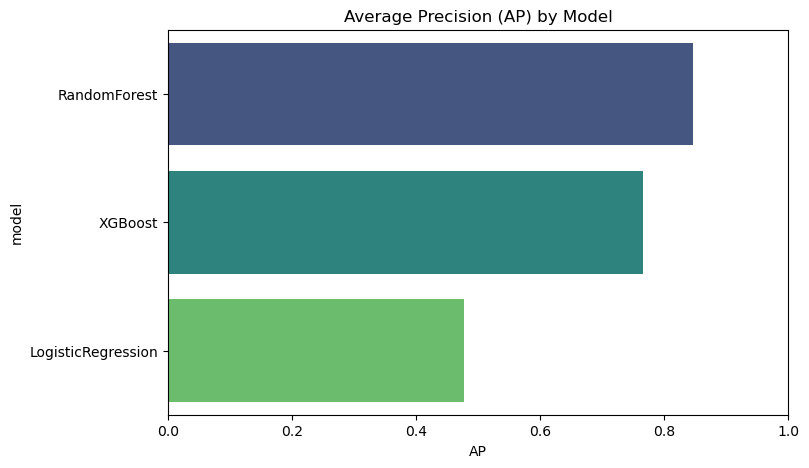

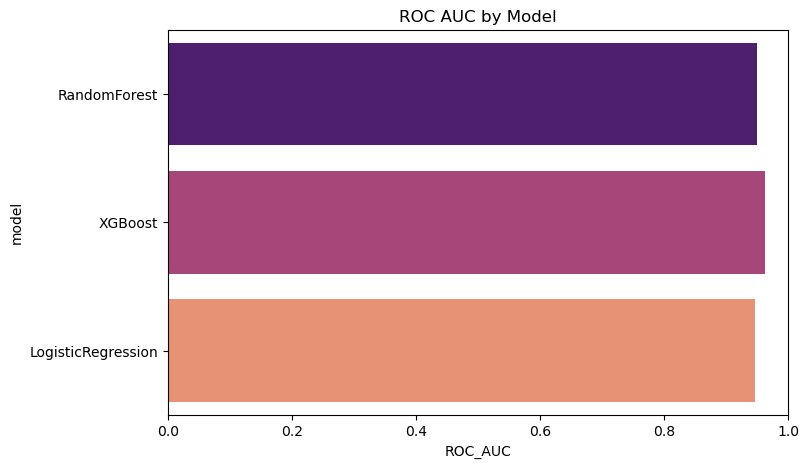

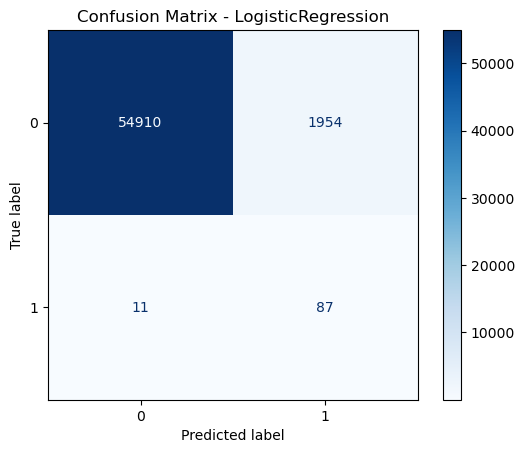

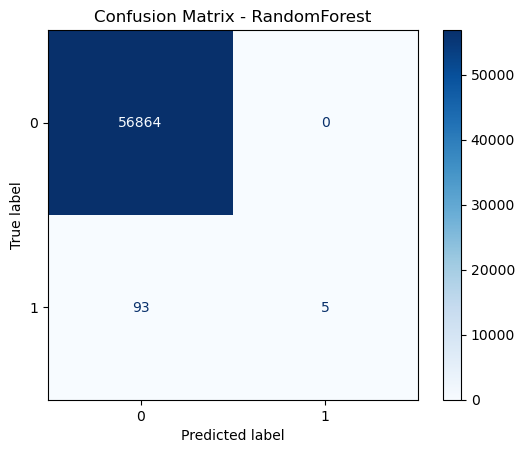

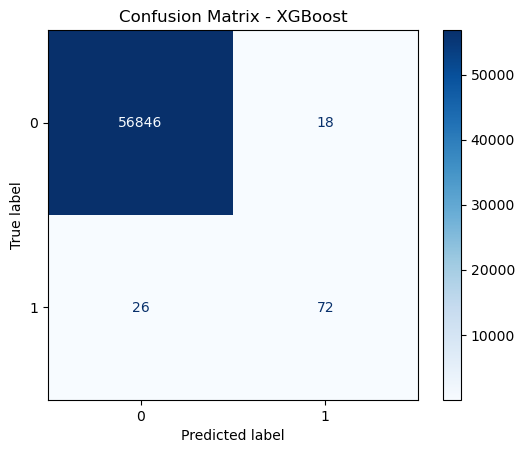

In [74]:
# 7. Evaluate all trained models
results_list = []

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

results_list = []

for name, model in trained_models.items():
    res = evaluate_model(model, X_test_proc, y_test)
    results_list.append({'model': name, 'AP': res['ap'], 'ROC_AUC': res['roc']})

res_df = pd.DataFrame(results_list).sort_values('AP', ascending=False)
print(res_df)

plt.figure(figsize=(8,5))
sns.barplot(x='AP', y='model', data=res_df, palette='viridis')
plt.title('Average Precision (AP) by Model')
plt.xlim(0,1)
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x='ROC_AUC', y='model', data=res_df, palette='magma')
plt.title('ROC AUC by Model')
plt.xlim(0,1)
plt.show()

for name, model in trained_models.items():
    y_pred = model.predict(X_test_proc)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()


In [71]:
# 8. Threshold tuning (example using best available model) and flag extraction
# Choosemodel with highest AP from res_df
from sklearn.metrics import precision_recall_curve
import numpy as np

best_model_name = res_df.iloc[0]['model']
model = trained_models[best_model_name]

print('Best model chosen:', best_model_name)

if hasattr(model, 'predict_proba'):
    y_scores = model.predict_proba(X_test_proc)[:,1]
else:
    s = model.decision_function(X_test_proc)
    y_scores = (s - s.min()) / (s.max() - s.min() + 1e-9)

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.nanargmax(f1_scores)
best_thresh = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

print('Best threshold by F1 on test:', best_thresh)

X_all_proc = prep(X)

if hasattr(model, 'predict_proba'):
    all_scores = model.predict_proba(X_all_proc)[:,1]
else:
    s = model.decision_function(X_all_proc)
    all_scores = (s - s.min()) / (s.max() - s.min() + 1e-9)

df_out = df.copy()
df_out['fraud_score'] = all_scores
df_out['pred_fraud'] = (df_out['fraud_score'] >= best_thresh).astype(int)

flagged = df_out[df_out['pred_fraud']==1].sort_values('fraud_score', ascending=False)
print('Flagged transactions count:', len(flagged))

flagged.head(20).to_csv('flagged_transactions.csv', index=False)
print('Saved flagged transactions to flagged_transactions.csv')


Best model chosen: RandomForest
Best threshold by F1 on test: 0.17
Flagged transactions count: 441
Saved flagged transactions to flagged_transactions.csv
